In [1]:
import os
from os.path import exists, join, basename, splitext

import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)

import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model = model.eval().cpu()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 48.2MB/s]


In [2]:
image_file = '/content/Comp_Vision_Task_5_File_2.jpg'

In [30]:
t = time.time()
image = PIL.Image.open(image_file)
image_tensor = torchvision.transforms.functional.to_tensor(image).cpu()
output = model([image_tensor])[0]
print('Время распознавания: %.3fs' % (time.time() - t))

Время распознавания: 9.292s


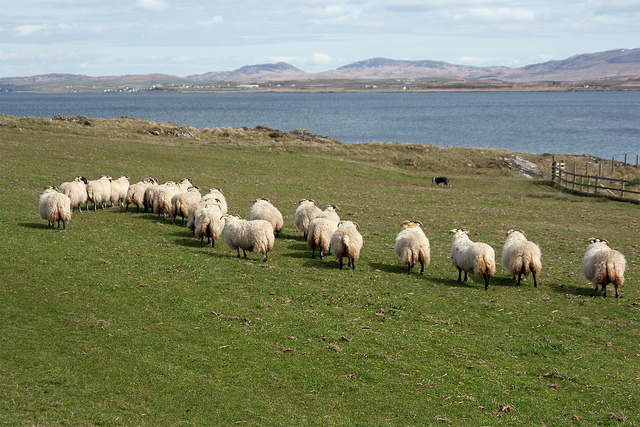

In [4]:
image

In [31]:
coco_names = ['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [32]:
result = {}
result['masks'] = []
result['labels'] = []
result['scores'] = []
result['boxes'] = []

for i in range(len(output['scores'])):
  if output['scores'][i] <= 0.5:
    continue
  # Исправляем маски
  one_mask = output['masks'][i][0].cpu().numpy()
  one_mask[one_mask >= np.max(one_mask) * 0.5] = 1
  one_mask[one_mask < np.max(one_mask) * 0.5] = 0
  result['masks'].append(one_mask)
  # Исправляем коробки
  result['boxes'].append(output['boxes'][i].int().cpu().numpy())
  # Добавляем остальное
  result['scores'].append(output['scores'][i].cpu().numpy())
  result['labels'].append(output['labels'][i].cpu().numpy())

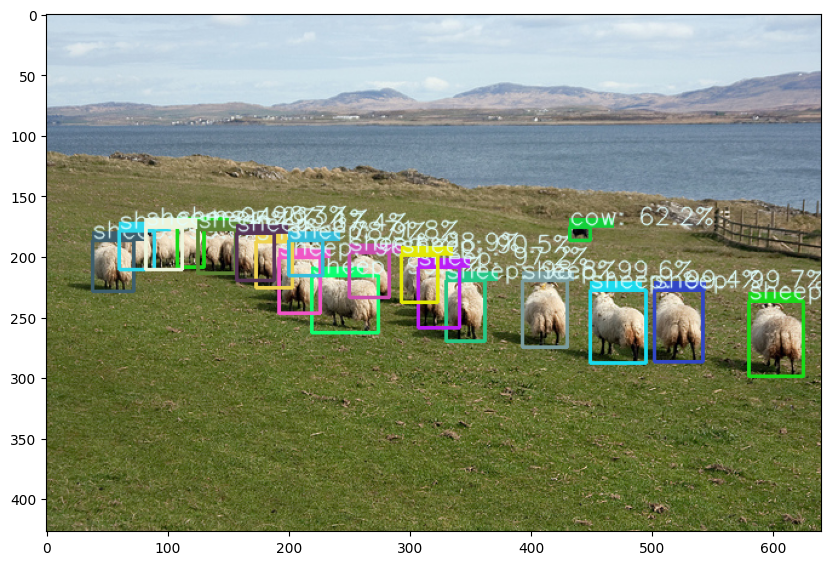

In [33]:
colors = [[random.randint(0, 255) for _ in range(3)] for _ in coco_names]

result_image = np.array(image.copy())
for box, label, score, mask in zip(result['boxes'], result['labels'], result['scores'], result['masks']):
  color = random.choice(colors)

  # draw box
  tl = round(0.002 * max(result_image.shape[0:2])) + 1  # line thickness
  c1, c2 = (box[0], box[1]), (box[2], box[3])
  cv2.rectangle(result_image, c1, c2, color, thickness=tl)
  # draw text
  display_txt = "%s: %.1f%%" % (coco_names[label], 100*score)
  tf = max(tl - 1, 1)  # font thickness
  #t_size = cv2.getTextSize(display_txt, 0, fontScale=tl / 3, thickness=tf)[0]
  t_size = cv2.getTextSize(display_txt, 0, fontScale=tl / 10, thickness=int(tf*0.1))[0]
  c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
  cv2.rectangle(result_image, c1, c2, color, -1)  # filled
  cv2.putText(result_image, display_txt, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

plt.figure(figsize=(10, 10))
plt.imshow(result_image)

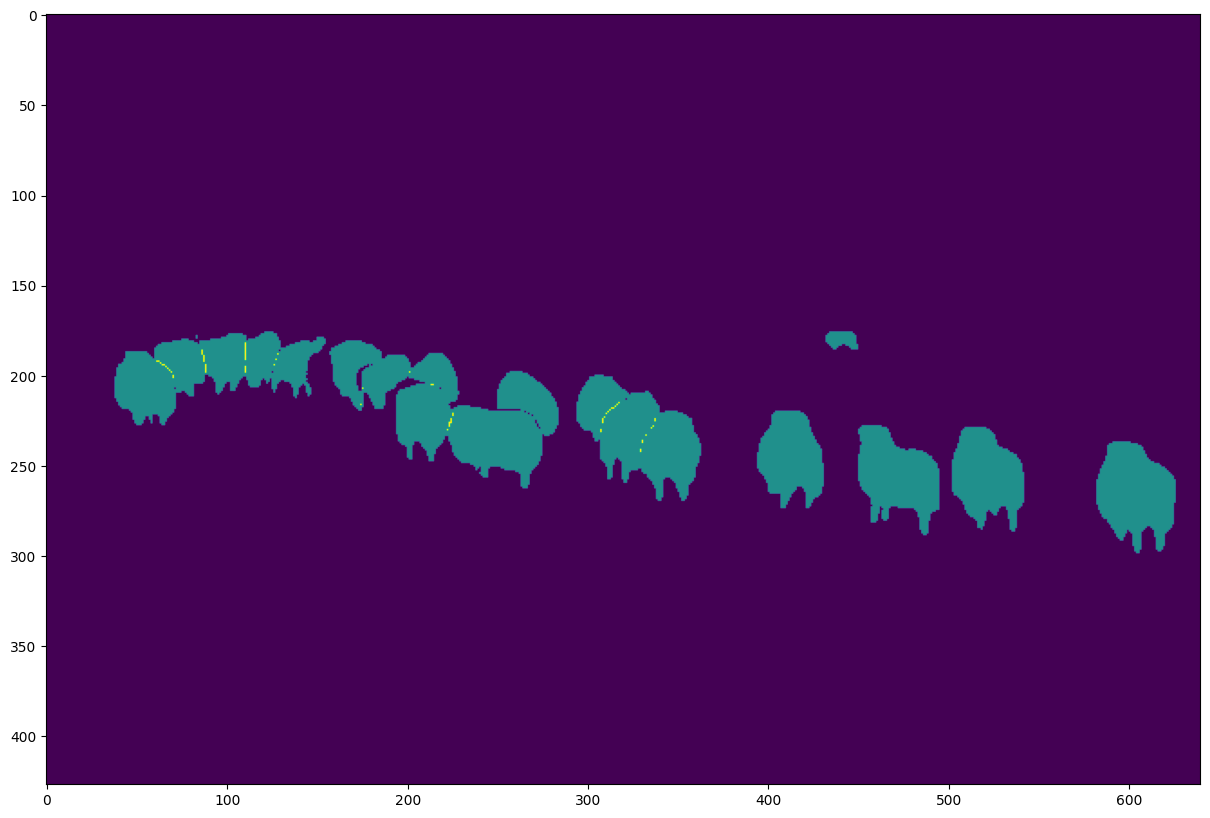

In [44]:
all_masks = np.sum(result['masks'],axis=0)
# all_masks[all_masks > 1] = 1
plt.figure(figsize=(15, 10))
plt.imshow(all_masks)

In [35]:
result['scores'][0]

array(0.99844944, dtype=float32)

In [36]:
result['masks'][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [47]:
import cv2
image = cv2.imread('Comp_Vision_Task_5_File_2.jpg')
# Get the height and width of the image
height, width, _ = image.shape

# Calculate the area in pixels
area_pixels = width * height

print(f"The area of the image in pixels is {area_pixels} pixels.")

The area of the image in pixels is 273280 pixels.


In [50]:
object_area / 273280

0.006901346604215456

In [18]:
# 1. Вычисляем площади сегментированных областей
areas = [np.sum(mask) for mask in result['masks']]

# 2. Находим индекс сегментированной области с наибольшей площадью
max_area_index = np.argmax(areas)

# 3. Получаем класс и вероятность этой сегментированной области
max_area_class = result['labels'][max_area_index]
max_area_score = result['scores'][max_area_index]

print(f"Объект с наибольшей площадью: {coco_names[max_area_class]}, Вероятность: {100*max_area_score:.2f}%")

Объект с наибольшей площадью: sheep, Вероятность: 99.84%


In [21]:
# Вычисляем площадь выбранной сегментированной области
selected_area = np.sum(result['masks'][max_area_index])

# Вычисляем общую площадь изображения (площадь маски всех объектов)
total_area = np.sum(all_masks)

# Вычисляем долю площади выбранного объекта относительно площади всего изображения
area_fraction = selected_area / total_area

print(f"Доля площади выбранного объекта относительно площади всего изображения: {area_fraction:.3f}%")

Доля площади выбранного объекта относительно площади всего изображения: 0.107%


In [22]:
# Получаем метку назначенного класса для выбранного объекта
selected_class_label = coco_names[max_area_class]

print(f"Метка назначенного класса выбранного объекта: {selected_class_label}")


Метка назначенного класса выбранного объекта: sheep


In [23]:
# Получаем координаты границ прямоугольника для выбранного объекта
selected_box = result['boxes'][max_area_index]

# Координаты прямоугольника (левый верхний угол и правый нижний угол)
x1, y1, x2, y2 = selected_box

print(f"Границы прямоугольника для выбранного объекта: (x1, y1) = ({x1}, {y1}), (x2, y2) = ({x2}, {y2})")


Границы прямоугольника для выбранного объекта: (x1, y1) = (580, 237), (x2, y2) = (625, 299)


In [24]:
x1, y1 = selected_box[:2]  # Это координаты x и y левого верхнего угла

print(f"Координаты левого верхнего угла прямоугольника: (x1, y1) = ({x1}, {y1})")

Координаты левого верхнего угла прямоугольника: (x1, y1) = (580, 237)


In [25]:
625 - 580

45

In [26]:
299 - 237

62